# 訓練サンプル0個で感情推定してみる

感情推定の訓練サンプル0個で、感情推定をしてみる


やること
- BERTのFill-Maskを使用する
    - 例）入力文：今日はいい天気で、散歩していて気持ちがいい。
        - 入力文の後に文章を追加：私の気持ちは\[MASK\]です。
        - FIll-maskにより、「嬉しい」「幸せ」と推定される
- 感情辞書と組み合わせて、「喜」「怒」などに分類する
    - 感情辞書には、ML-Askの辞書を使用する

## 環境構築
- Transformers (日本語使用)

In [1]:
! pip install transformers[ja]==4.21.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import glob

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix

## Matplotlibで日本語を使用できるようにする

In [3]:
# [前準備] Matplotlib で日本語フォントを使用できるようにする
# cf. https://blog.3qe.us/entry/2018/08/16/121457
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v310.json

# NOTE ここで、ランタイムを再起動

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


Text(0.5, 1.0, '日本語を表示できるかテスト')

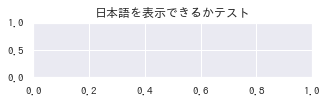

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')

# 動作確認
plt.figure(figsize=(5,1))
plt.title('日本語を表示できるかテスト')

## Fill-Maskで感情推定を試してみる

In [5]:
from transformers import pipeline, AutoTokenizer

# 使用するモデルを指定して、トークナイザとモデルを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
unmasker = pipeline('fill-mask', model=checkpoint, tokenizer=tokenizer, device=0)  # GPU使用は明示的にdevice指定が必要？

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
text = '今日はいい天気で、散歩していて気持ちがいい。'
template = '私の気持ちは[MASK]です。'  # [MASK]が予測対象
unmasker(text + template)

[{'score': 0.20724758505821228,
  'token': 12453,
  'token_str': '元 気',
  'sequence': '今日 は いい 天気 で 、 散歩 し て い て 気持ち が いい 。 私 の 気持ち は 元気 です 。'},
 {'score': 0.06613747775554657,
  'token': 13215,
  'token_str': '幸 せ',
  'sequence': '今日 は いい 天気 で 、 散歩 し て い て 気持ち が いい 。 私 の 気持ち は 幸せ です 。'},
 {'score': 0.038396257907152176,
  'token': 26051,
  'token_str': 'ま っ す ぐ',
  'sequence': '今日 は いい 天気 で 、 散歩 し て い て 気持ち が いい 。 私 の 気持ち は まっすぐ です 。'},
 {'score': 0.03444681689143181,
  'token': 2575,
  'token_str': 'い い',
  'sequence': '今日 は いい 天気 で 、 散歩 し て い て 気持ち が いい 。 私 の 気持ち は いい です 。'},
 {'score': 0.031215133145451546,
  'token': 16665,
  'token_str': 'ハ ッ ピ ー',
  'sequence': '今日 は いい 天気 で 、 散歩 し て い て 気持ち が いい 。 私 の 気持ち は ハッピー です 。'}]

## 感情単語辞書を用いた感情分類

- ML-Askの感情辞書をダウンロードして読み込む
- Fill-Maskの出力を感情辞書と照合し、感情毎のスコアを算出

### 感情辞書の読み込み

In [7]:
# ML-Askの感情単語辞書をダウンロードする
# http://arakilab.media.eng.hokudai.ac.jp/~ptaszynski/repository/mlask.htm
! wget http://arakilab.media.eng.hokudai.ac.jp/~ptaszynski/ccount/click.php?id=3 -O emotions.zip
! unzip -o emotions.zip

--2022-09-10 10:18:23--  http://arakilab.media.eng.hokudai.ac.jp/~ptaszynski/ccount/click.php?id=3
Resolving arakilab.media.eng.hokudai.ac.jp (arakilab.media.eng.hokudai.ac.jp)... 133.87.189.142
Connecting to arakilab.media.eng.hokudai.ac.jp (arakilab.media.eng.hokudai.ac.jp)|133.87.189.142|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://arakilab.media.eng.hokudai.ac.jp/~ptaszynski/repository/files/emotions.zip [following]
--2022-09-10 10:18:23--  http://arakilab.media.eng.hokudai.ac.jp/~ptaszynski/repository/files/emotions.zip
Connecting to arakilab.media.eng.hokudai.ac.jp (arakilab.media.eng.hokudai.ac.jp)|133.87.189.142|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12520 (12K) [application/zip]
Saving to: ‘emotions.zip’

emotions.zip        100%[===================>]  12.23K  --.-KB/s    in 0.1s    

2022-09-10 10:18:23 (124 KB/s) - ‘emotions.zip’ saved [12520/12520]

Archive:  emotions.zip
  inflating: emotions/aware_u

In [8]:
# 感情辞書を読み込む
# emotion_dict = {'yorokobi': ['喜', '幸せ', ...], ...}
emotion_dict_files = glob.glob(os.path.join('emotions', '*.txt'))
emotion_dict = {}
for filepath in emotion_dict_files:
    em_name = os.path.basename(filepath).split('_')[0]  # aware_uncoded.txt --> aware
    emotion_dict[em_name] = [x.replace('\n', '') for x in open(filepath, 'r').readlines()]

print(len(emotion_dict['yorokobi']))
print(emotion_dict['yorokobi'][:10])

224
['さんぱいきゅうはい', '気持ちが晴れ渡る', 'ありがたなみだ', 'つかえが下がる', '悪い気がしない', '嬉しがらせる', 'かたじけない', '晴れ晴れしい', '気持ちがよい', '気持ちがいい']


### Fill-Maskの出力を感情辞書と照合し、感情毎のスコアを算出

In [9]:
def search_emotion_dict(word):
    """感情辞書を検索し、どの感情の単語かを返す."""
    for name, words in emotion_dict.items():
        if word in words:
            return name
    return None

# お試し
print(search_emotion_dict('幸せ'))
print(search_emotion_dict('残念'))
print(search_emotion_dict('苦しい'))
print(search_emotion_dict('悲しい'))
print(search_emotion_dict('怖い'))
print(search_emotion_dict('びっくり'))
print(search_emotion_dict('恥ずかしい'))
print(search_emotion_dict('腹立たしい'))
print(search_emotion_dict('いらいら'))
print(search_emotion_dict('不幸'))

yorokobi
iya
iya
aware
kowa
odoroki
haji
ikari
None
None


In [10]:
def analayze_emotion_by_fillmask(text, ret_words=False):
    """Fill-Maskにより感情推定をする.

    Args:
        text (str): 入力文
        ret_words (bool): Fill-Maskの出力（感情を含む単語のみ）を返すかどうか
    Returns:
        list[(str, float)]: 各感情スコア
        list[str]: Fill-Mask出力. ret_words=Trueの場合のみ
    """
    emotion_names = list(emotion_dict.keys())

    # 追加する文章
    templates = [
        # '私の気持ちは[MASK]です。',
        '私は[MASK]です。',
        '私は[MASK]ました。',
        '私は[MASK]しました。',
        '私は[MASK]気持ちです。',
        '私は[MASK]に感じました。',
        ]
    
    # Fill-Maskを実行
    results = []
    for template in templates:
        results += unmasker(text + template)
    
    # 感情辞書と照合
    # 各感情のスコアの総和を算出
    emotion_scores = {em_name : 0 for em_name in emotion_names}
    pred_words = []
    for result in results:
        pred_word = result['token_str'].replace(' ', '')  # 推定された単語
        pred_score = result['score']                    # スコア
        em_name = search_emotion_dict(pred_word)  # 感情辞書と照合
        if em_name is not None:
            emotion_scores[em_name] += pred_score
        pred_words.append(pred_word)
    
    # 正規化する（スコアの総和を1にする）
    score_sum = max(sum(emotion_scores.values()), 0.01)
    emotion_scores = {n: v / score_sum for n, v in emotion_scores.items()}
    # スコアの高い順に並び変える
    pred_emotions = sorted(emotion_scores.items(), key=lambda x: x[1], reverse=True)

    if ret_words:
        return pred_emotions, pred_words
    return pred_emotions

# 動作確認
analayze_emotion_by_fillmask("娘が美味しいディナーをご馳走してくれた。")

[('yorokobi', 0.7397981347214723),
 ('takaburi', 0.13628165899830047),
 ('odoroki', 0.09237053940582399),
 ('aware', 0.01869053703336922),
 ('suki', 0.01285912984103407),
 ('iya', 0.0),
 ('ikari', 0.0),
 ('yasu', 0.0),
 ('kowa', 0.0),
 ('haji', 0.0)]

In [11]:
analayze_emotion_by_fillmask("急な豪雨のせいで靴の中までビショビショだぁ。サイアク……。")

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1039: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


[('aware', 0.43748155996739013),
 ('iya', 0.35120610875559644),
 ('kowa', 0.16544351225027987),
 ('odoroki', 0.04586881902673359),
 ('yorokobi', 0.0),
 ('ikari', 0.0),
 ('takaburi', 0.0),
 ('yasu', 0.0),
 ('haji', 0.0),
 ('suki', 0.0)]

In [12]:
analayze_emotion_by_fillmask("え、こんなことってある…！？")

[('odoroki', 0.5942357359062117),
 ('takaburi', 0.16119977149327488),
 ('kowa', 0.12915757727104055),
 ('iya', 0.11540691532947288),
 ('yorokobi', 0.0),
 ('ikari', 0.0),
 ('yasu', 0.0),
 ('aware', 0.0),
 ('haji', 0.0),
 ('suki', 0.0)]

In [13]:
analayze_emotion_by_fillmask("何て野郎だ。礼儀というものを知らないのか？")

[('iya', 0.41336075134074773),
 ('odoroki', 0.3184270489031058),
 ('yorokobi', 0.1693133082776712),
 ('ikari', 0.09889889147847526),
 ('takaburi', 0.0),
 ('yasu', 0.0),
 ('aware', 0.0),
 ('kowa', 0.0),
 ('haji', 0.0),
 ('suki', 0.0)]

In [14]:
analayze_emotion_by_fillmask("え……。私が見たのって、もしかして幽霊……？？")

[('odoroki', 0.32226663348226553),
 ('kowa', 0.20905030671805694),
 ('iya', 0.20384158484796533),
 ('aware', 0.16927653086986397),
 ('takaburi', 0.09556494408184822),
 ('yorokobi', 0.0),
 ('ikari', 0.0),
 ('yasu', 0.0),
 ('haji', 0.0),
 ('suki', 0.0)]

## WRIMEデータセットで評価してみる
- 感情分類タスクでの精度感を評価してみる
- WRIMEデータセット：日本語の感情分析の研究用データセット
    - https://github.com/ids-cv/wrime
    

### WRIMEデータセットの準備

In [15]:
! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv

--2022-09-10 10:18:25--  https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv [following]
--2022-09-10 10:18:25--  https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9487237 (9.0M) [text/plain]
Saving to: ‘wrime-ver1.tsv.3’

wrime-ver1.tsv.3    100%[===================>]   9.05M  --.-KB/s    in 0.03s   

2022-09-10 10:18:27 (270 MB/s) - ‘wrime-ver1.tsv.3’ saved [9487237/9487237]



In [16]:
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.head(2)

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Disgust,Reader3_Trust,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,1,2012/07/31 23:48,train,0,1,2,1,1,0,...,1,0,0,2,0,0,0,0,0,0
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,1,2012/08/02 23:09,train,3,0,3,0,0,0,...,0,1,1,0,0,2,0,0,0,0


In [17]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']  # 日本語版
num_labels = len(emotion_names)

# readers_emotion_intensities 列を生成する
# "Avg. Readers_*" の値をlist化したもの
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

# 感情強度が高い感情が１つのサンプルを対象とする
# (readers_emotion_intensities が２以上の要素が一点のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: np.sum(np.array(x) >= 2) == 1)
df_wrime_target = df_wrime[is_target].copy()

# 感情ラベルに変換する
df_wrime_target['emotion_label'] = df_wrime_target['readers_emotion_intensities'].map(lambda x: emotion_names_jp[np.argmax(x)])

df_wrime_target['emotion_label'].value_counts()

喜び     4164
期待     3859
悲しみ    2790
驚き     1865
恐れ     1487
嫌悪      889
怒り      163
信頼       40
Name: emotion_label, dtype: int64

In [18]:
# train / test に分割する
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))
print('test :', len(df_test))

train : 14227
test : 1030


### 評価

In [19]:
# WRIMEの感情分類に合わせた形式で出力する
convert_table = {
    'yorokobi': '喜び',
    'takaburi': '期待',
    'odoroki': '驚き',
    'aware': '悲しみ',
    'suki': '喜び',
    'iya': '嫌悪',
    'yasu': '喜び',
    'haji': '嫌悪',  # ?
    'kowa': '恐れ',
    'ikari': '怒り'
}

def prediction_for_wrime(text):
    pred = analayze_emotion_by_fillmask(text)
    em_name, score = pred[0]
    wrime_em_name = convert_table[em_name]
    return wrime_em_name

prediction_for_wrime("今日は久々に良い天気だ！")

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1039: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


'喜び'

In [20]:
# 評価する
results = []
for index, row in df_test.iterrows():
    text = row['Sentence']
    label = row['emotion_label']
    pred = prediction_for_wrime(text)
    results.append([text, label, pred])

In [21]:
# 正解率
res_arr = np.array(results)
y_true = res_arr[:, 1]
y_pred = res_arr[:, 2]

acc = np.mean(y_true == y_pred)
acc

0.31359223300970873

In [22]:
# 各感情に関して、Precision, Recallを求める
report = classification_report(y_true, y_pred, output_dict=True, labels=emotion_names_jp)
df_report = pd.DataFrame(report).transpose()

df_report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
喜び,0.440389,0.567398,0.495890,319.000000
悲しみ,0.340426,0.092486,0.145455,173.000000
期待,0.373333,0.093645,0.149733,299.000000
驚き,0.342593,0.462500,0.393617,80.000000
怒り,0.000000,0.000000,0.000000,7.000000
恐れ,0.220930,0.223529,0.222222,85.000000
嫌悪,0.138614,0.656250,0.228883,64.000000
信頼,0.000000,0.000000,0.000000,3.000000
accuracy,0.313592,0.313592,0.313592,0.313592
macro avg,0.232036,0.261976,0.204475,1030.000000


Text(38.9375, 0.5, 'GT')

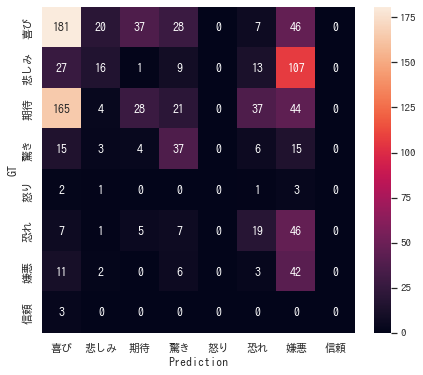

In [23]:
# Confusion Matrixを描画する
cm_arr = confusion_matrix(y_true, y_pred, labels=emotion_names_jp)
df_cm = pd.DataFrame(cm_arr, index=emotion_names_jp, columns=emotion_names_jp)
plt.figure(figsize=(7,6))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('GT')
# sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')

## 参考）推定結果を棒グラフとして出力する

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1039: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


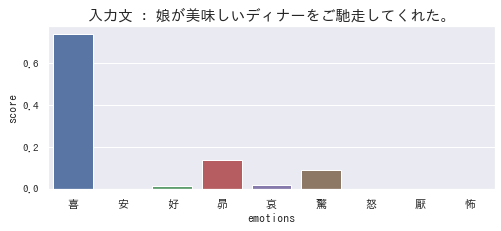

In [24]:
def analyze_and_showfig(text):
    # 推論
    pred = analayze_emotion_by_fillmask(text)

    # ラベル名を変更 e.g.) yorokobi --> "喜"
    emotion_labels = {'ikari': '怒', 'suki': '好', 'haji': '恥', 'iya': '厭', 'kowa': '怖', 'aware': '哀', 'odoroki': '驚', 'yasu': '安', 'takaburi': '昴', 'yorokobi': '喜'}
    out_dict = {emotion_labels[em_name]: score for em_name, score in pred}
    out_list = [[em, out_dict[em]] for em in ['喜', '安', '好', '昴', '哀', '驚', '怒', '厭', '怖']]

    # 棒グラフを描画
    plt.figure(figsize=(8, 3))
    df = pd.DataFrame(out_list, columns=['emotions', 'score'])
    sns.barplot(x='emotions', y='score', data=df)
    plt.title('入力文 : ' + text, fontsize=15)

analyze_and_showfig("娘が美味しいディナーをご馳走してくれた。")

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1039: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


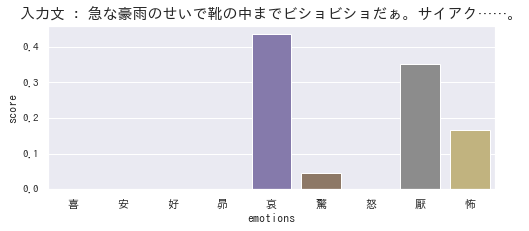

In [25]:
analyze_and_showfig("急な豪雨のせいで靴の中までビショビショだぁ。サイアク……。")

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1039: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


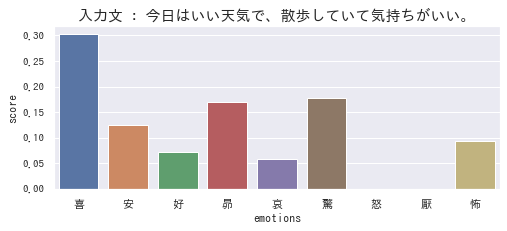

In [26]:
analyze_and_showfig('今日はいい天気で、散歩していて気持ちがいい。')

## 参考）ML-Askで分類してみる

In [27]:
# ML-Askのインストール
! pip install pymlask
! apt install aptitude
! aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
! pip install mecab-python3==0.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.12)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.19)
xz-utils is already installed at the requested version (5.2.2-1.3ubuntu0.1)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the r

In [28]:
from mlask import MLAsk
emotion_analyzer = MLAsk()
emotion_analyzer.analyze('今日はいい天気で、散歩していて気持ちがいい。')

{'text': '今日はいい天気で、散歩していて気持ちがいい。',
 'emotion': defaultdict(list, {'yorokobi': ['気持ちがいい']}),
 'orientation': 'POSITIVE',
 'activation': 'NEUTRAL',
 'emoticon': None,
 'intension': 0,
 'intensifier': {},
 'representative': ('yorokobi', ['気持ちがいい'])}

In [29]:
def mlask_prediction_for_wrime(text):
    res = emotion_analyzer.analyze(text)
    if res['emotion'] is None:
        return '感情なし'
    else:
        em_name = res['representative'][0]
        wrime_em_name = convert_table[em_name]
        return wrime_em_name

results_mlask = []
for index, row in df_test.iterrows():
    text = row['Sentence']
    label = row['emotion_label']
    pred = mlask_prediction_for_wrime(text)
    results_mlask.append([text, label, pred])

In [30]:
# 正解率
res_arr_mlask = np.array(results_mlask)
y_true = res_arr_mlask[:, 1]
y_pred = res_arr_mlask[:, 2]

acc = np.mean(y_true == y_pred)
acc

0.2203883495145631

In [31]:
# 各感情に関して、Precision, Recallを求める
report = classification_report(y_true, y_pred, output_dict=True, labels=emotion_names_jp)
df_report = pd.DataFrame(report).transpose()
df_report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
喜び,0.700000,0.504702,0.586521,319.0
悲しみ,0.562500,0.104046,0.175610,173.0
期待,0.111111,0.003344,0.006494,299.0
驚き,0.681818,0.187500,0.294118,80.0
怒り,0.100000,0.142857,0.117647,7.0
恐れ,0.818182,0.211765,0.336449,85.0
嫌悪,0.178082,0.203125,0.189781,64.0
信頼,0.000000,0.000000,0.000000,3.0
micro avg,0.570352,0.220388,0.317927,1030.0
macro avg,0.393962,0.169667,0.213327,1030.0


Text(38.9375, 0.5, 'GT')

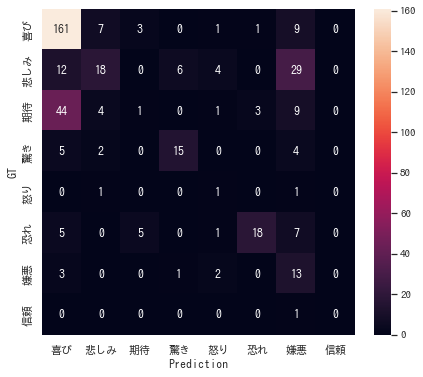

In [32]:
# Confusion Matrixを描画する
cm_arr = confusion_matrix(y_true, y_pred, labels=emotion_names_jp)
df_cm = pd.DataFrame(cm_arr, index=emotion_names_jp, columns=emotion_names_jp)
plt.figure(figsize=(7,6))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('GT')

## 参考）BoW+ロジスティック回帰

In [33]:
# 分かち書き用にGiNZAをインストール
! pip install -U ginza ja_ginza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
# GiNZAで分かち書き
import spacy
nlp = spacy.load('ja_ginza')

def wakati_preprocess(text):
    """分かち書き. 各単語はlemma（原形）に変換しておく."""
    doc = nlp(text)
    lemmas = []
    for sent in doc.sents:
        for token in sent:
            lemmas.append(token.lemma_)
    return ' '.join(lemmas)

In [35]:
# 前処理
docs_train = [wakati_preprocess(text) for text in df_train['Sentence'].values]
docs_test = [wakati_preprocess(text) for text in df_test['Sentence'].values]

In [36]:
y_train = [emotion_names_jp.index(label) for label in df_train['emotion_label'].values]
y_test = [emotion_names_jp.index(label) for label in df_test['emotion_label'].values]

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# BoW (CountVectorizer)
bow_vectorizer = CountVectorizer(max_df=0.5, min_df=0.001, stop_words=[])
bow_vectorizer.fit(docs_train)
x_train = bow_vectorizer.transform(docs_train).toarray()

# ロジスティック回帰
logreg = LogisticRegression(max_iter=1000)

# 訓練
logreg.fit(x_train, y_train)

# 評価サンプルに適用
x_test = bow_vectorizer.transform(docs_test).toarray()
_y_pred_bow = logreg.predict(x_test)

In [38]:
# 正解率
y_true_bow = np.array([emotion_names_jp[i] for i in y_test])
y_pred_bow = np.array([emotion_names_jp[i] for i in _y_pred_bow])
acc = np.mean(y_true_bow == y_pred_bow)
print(acc)

0.6223300970873786


In [39]:
# 各感情に関して、Precision, Recallを求める
report = classification_report(y_true_bow, y_pred_bow, output_dict=True, labels=emotion_names_jp)
df_report = pd.DataFrame(report).transpose()
df_report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
喜び,0.669312,0.793103,0.725968,319.00000
悲しみ,0.502825,0.514451,0.508571,173.00000
期待,0.708054,0.705686,0.706868,299.00000
驚き,0.505618,0.562500,0.532544,80.00000
怒り,0.000000,0.000000,0.000000,7.00000
恐れ,0.516129,0.376471,0.435374,85.00000
嫌悪,0.458333,0.171875,0.250000,64.00000
信頼,0.000000,0.000000,0.000000,3.00000
accuracy,0.622330,0.622330,0.622330,0.62233
macro avg,0.420034,0.390511,0.394916,1030.00000


Text(38.9375, 0.5, 'GT')

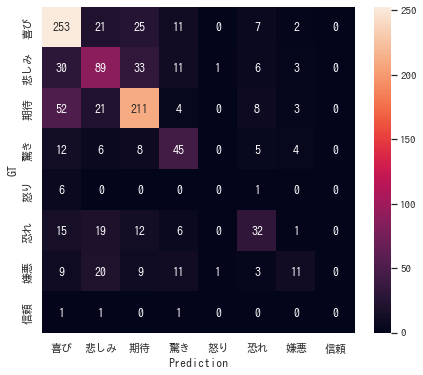

In [40]:
# Confusion Matrixを描画する
cm_arr = confusion_matrix(y_true_bow, y_pred_bow, labels=emotion_names_jp)
df_cm = pd.DataFrame(cm_arr, index=emotion_names_jp, columns=emotion_names_jp)
plt.figure(figsize=(7,6))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('GT')

## 参考）GPU使用状況を確認
- 当初、GPUを使用できておらず、推論が遅かった
- `pipeline(*, device=0)`とdeviceを明示的に指定することで解決

In [41]:
! pip install nvidia-ml-py3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

print_gpu_utilization()

GPU memory occupied: 1502 MB.
